In [9]:
import pandas as pd
import sentencepiece as spm
import numpy as np
import os
from konlpy.tag import Mecab
import re
pd.options.display.max_rows=100

In [90]:
dir_path = os.getenv("HOME") +'/aiffel/DATA'

In [203]:
df = pd.read_csv(dir_path + '/meta_raw_eng_corrected_sts_v_final.csv', index_col ='Unnamed: 0')

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949888 entries, 0 to 949887
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   reg          949888 non-null  object 
 1   topic        949888 non-null  object 
 2   stdn         949888 non-null  object 
 3   dial         949888 non-null  object 
 4   eng          949888 non-null  object 
 5   eojeol_stdn  949888 non-null  object 
 6   sts          949888 non-null  float64
dtypes: float64(1), object(6)
memory usage: 58.0+ MB


In [205]:
def cleaning_kor(sentence):
    sentence =  re.sub(r'(.+)\1{2,}',r'\1', sentence)
    sentence = re.sub('( .)(~)(?<=~)','',sentence)
    sentence =  re.sub(r'(\-)(\w*)(\-)','', sentence)
    sentence = re.sub(r' +', ' ',sentence)
    return sentence

In [206]:
def cleaning_eng(sentence):
    sentence =  re.sub('homets','home training', sentence)
    sentence =  re.sub(r'(.+)\1{2,}',r'\1', sentence)
    sentence = re.sub('( .)(~)(?<=~)','',sentence)
    sentence =  re.sub(r'(\-)(\w*)(\-)','', sentence)
    sentence = re.sub(r' +', ' ',sentence)
    return sentence

In [207]:
dial = df.dial.values
eng = df.eng.values

In [208]:
import tqdm
new_dial = []
new_eng = []
for sentence in tqdm.tqdm(zip(dial,eng)) :
    new_dial.append(cleaning_kor(sentence[0]))
    new_eng.append(cleaning_kor(sentence[1]))

949888it [01:21, 11683.99it/s]


In [209]:
df['dial_n'] = new_dial
df['eng_n'] = new_eng

In [210]:
df.head()

,reg,topic,stdn,dial,eng,eojeol_stdn,sts,dial_n,eng_n
0,jd,역사,생각이 쪼금씩 바뀌더라고,생각이 쪼금씩 바뀌드라고,I've changed my mind a little bit.,[['(바뀌드라고)/(바뀌더라고)']],0.056177,생각이 쪼금씩 바뀌드라고,I've changed my mind a little bit.
1,jd,가족,어 알겠는가 외국인들이 그래도 잘 적응하고,어 알겄는가 외국인들이 그래도 잘 적응하고,You know what? Foreigners still get used to it.,[['(알겄는가)/(알겠는가)']],-0.006247,어 알겄는가 외국인들이 그래도 잘 적응하고,You know what? Foreigners still get used to it.
2,jd,건강,아으 갑자기 예전에 맹장 뜯은 게 생각난다.,아으 갑자기 예전에 맹장 뜯은 게 생각난디야.,"All of a sudden, I think I've ripped off my ap...",[['(생각난디야.)/(생각난다.)']],0.174105,아으 갑자기 예전에 맹장 뜯은 게 생각난디야.,"All of a sudden, I think I've ripped off my ap..."
3,jd,스타일,보면은 조금 품위 있게 나이 들어가야 되겠단 생각을 참 많이 해요.,보면은 쫌 품위 있게 나이 들어가야 되겠단 생각을 참 많이 해요.,I have a lot of ideas about getting older in a...,[['(쫌)/(조금)']],0.120993,보면은 쫌 품위 있게 나이 들어가야 되겠단 생각을 참 많이 해요.,I have a lot of ideas about getting older in a...
4,jd,먹거리,약간 조금 약간 맛이 쪼끔 거시기 하긴 한데 그래도,약간 쫌 약간 맛이 쪼끔 거시기 하긴 한데 그래도,"It's a little bit of a tastey, but still...",[['(쫌)/(조금)']],0.256973,약간 쫌 약간 맛이 쪼끔 거시기 하긴 한데 그래도,"It's a little bit of a tastey, but still."


In [211]:
df.loc[df.dial_n.str.contains(r'(.+)\1{2,}', regex=True),'delete'] = True
df.loc[df.dial_n.str.contains('[@&]'),'delete'] = True
df.loc[df.eng.str.contains('dick'),'delete'] = True

/tmp/ipykernel_5108/2270625428.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df.loc[df.dial_n.str.contains(r'(.+)\1{2,}', regex=True),'delete'] = True


In [212]:
df = df.loc[df.delete!=True]

In [213]:
regs = df.reg.unique().tolist()
jd_e,jj_e, cc_e, gs_e, kw_e = dict(),dict(),dict(),dict(),dict()
eojs = [jd_e,jj_e, cc_e, gs_e, kw_e]

In [214]:
for reg, eoj in zip(regs, eojs) :
    eoj['eojels'] = df.loc[df['reg'] == reg,'eojeol_stdn'].values

In [215]:
import re

pairs = {}

for reg, eoj in zip(regs,eojs) :
    pairs[reg] = {}
    for i in eoj['eojels'] :
        match = re.search(r'(?<=\()(\w*)(?=\))',i)
        tg_match = re.search(r'(?<=\/\()(\w*)(?=\))',i)
        if match and tg_match:
            dial = re.search(r'(?<=\()(\w*)(?=\))',i).group()
            src = re.search(r'(?<=\/\()(\w*)(?=\))',i).group()
            if len(src) > 2 :
                pairs[reg].update({src : dial})

In [216]:
for reg, eoj in zip(regs,eojs) :
    temp = df.loc[df['reg'] == reg]
    temp_dial = temp.dial_n.values
    temp_stdn = temp.stdn.values
    test_dial_v = []
    temp_reg = [reg for _ in range(len(temp))]

    for sentence in temp_dial :
        new = []
        for x in sentence.split() :
            try :
                new.append(pairs[reg][x])
            except :
                new.append(x)
        test_dial_v.append(' '.join(new))
    df.loc[df['reg'] == reg,'dial_edit']= test_dial_v

In [217]:
#시소러스 불러오기
import json
with open('eojeol_subs.json','r') as f :
    tjv = json.load(f)

In [218]:
for reg in regs :
    with open('test.txt','w') as f:
        for i in df[df['reg'] == reg].dial_edit.values :
            f.write(i +' \n')

    with open('test.txt','r') as f:
        raw = f.read()

    for rx, sb in tjv[reg] :
        raw = re.sub("{}".format(rx),sb,raw)

    df.loc[df['reg'] == reg,'dial_edit'] = raw.splitlines()

In [108]:
data_path = os.getenv('HOME') +'/aiffel/saturi/notebook/Preprocessing'
spm_8000 = spm.SentencePieceProcessor()
spm_8000.Load(data_path + '/spm_dec_8009.model')

msp_8000 = spm.SentencePieceProcessor()
msp_8000.Load(data_path + '/spm_dec_msp8009.model')

custom_msp_8000 =  spm.SentencePieceProcessor()
custom_msp_8000.Load(data_path + '/spm_dec_custom_msp8009.model')

True

In [219]:
use_col = ['reg', 'topic', 'stdn', 'eng','dial_n','eng_n', 'dial_edit']

In [220]:
df_t = df[use_col].copy()

In [186]:
tokenizers_8000 = {'spm' : spm_8000, 'msp' : msp_8000, 'custom_msp' : custom_msp_8000}

In [187]:
import re 
df_t['dial_r'] = df_t['dial_n'].apply(lambda x : re.sub('[?.!@]',' ', x))
df_t['dial_edit_r'] = df_t['dial_edit'].apply(lambda x : re.sub('[?.!@]',' ', x))

In [188]:
regs = df.reg.unique()

In [114]:
import seaborn as sns
from nltk import ngrams
import tqdm
import matplotlib.pyplot as plt
colors = ['#F16F6F','#F6C456','#FDFE65','#AFE64D','#9FD5FC']

def uni_bi_distribution_plot(tokenizer_dic, row, col, df_train, variable):
    fig = plt.figure(figsize=(10,10))
    z = 0
    for i, tok in enumerate(tokenizer_dic.items()) :
        key, tokenizer = tok
        for n,reg in enumerate(regs) :
            # unigram
            dial = df_train.loc[df_train['reg'] == reg,variable].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                tokenized.extend(tok_encode)

            # Barplot that shows the top most common

            sns_pos_1 = plt.subplot(row,col,z+i+1)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

            # Setting axes labels
            sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Unigram Token Distribution by Region')
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.legend()

        # bigram
        tok_dict = {}
        idx = 0
        for n,reg in enumerate(regs) :
            dial = df_train.loc[df_train['reg'] == reg,variable].values
            tokenized = []
            for k in tqdm.tqdm(dial) :
                tok_encode = tokenizer.encode(k)
                n_grams = ngrams(tok_encode,2)
                for ng in n_grams :
                    try :
                        tokenized.append(tok_dict[ng])
                    except :
                        idx += 1
                        tok_dict[ng] = idx  
                        tokenized.append(tok_dict[ng])

            sns_pos_1 = plt.subplot(row,col,z+i+2)
            sns.set(font_scale = .5, style = 'whitegrid')
            sns_pos_1 = sns.kdeplot(tokenized,color=colors[n], label=reg, fill=True)

        # Setting axes labels
        sns_pos_1.set(xlabel = 'Occurrence', ylabel = 'Vocab', title = f'{key} : Bigram Token Distribution by Region')
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend()
        z +=1

    plt.tight_layout()
    plt.show()

100%|████████████████████████████████| 344457/344457 [00:07<00:00, 49110.90it/s]


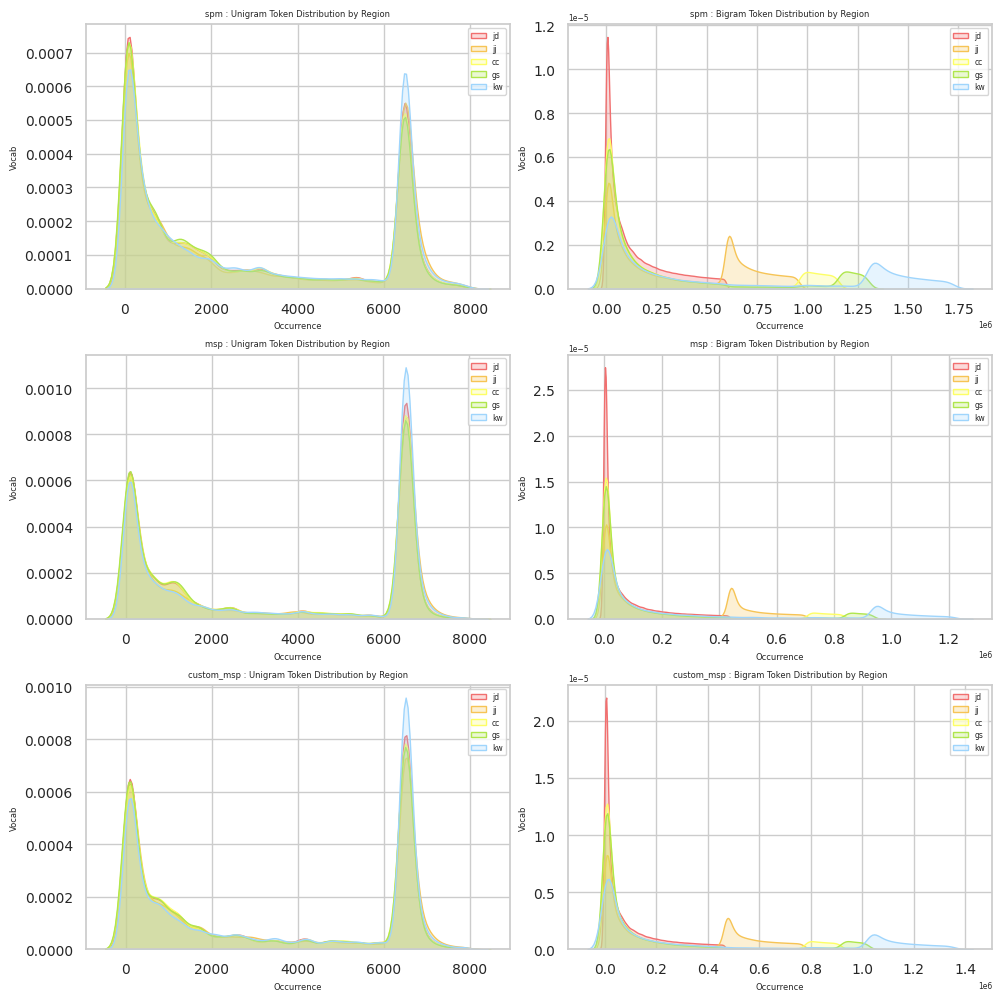

In [115]:
uni_bi_distribution_plot(tokenizers_8000, 3, 2, df_t, 'dial_r')

100%|████████████████████████████████| 344457/344457 [00:07<00:00, 47656.12it/s]


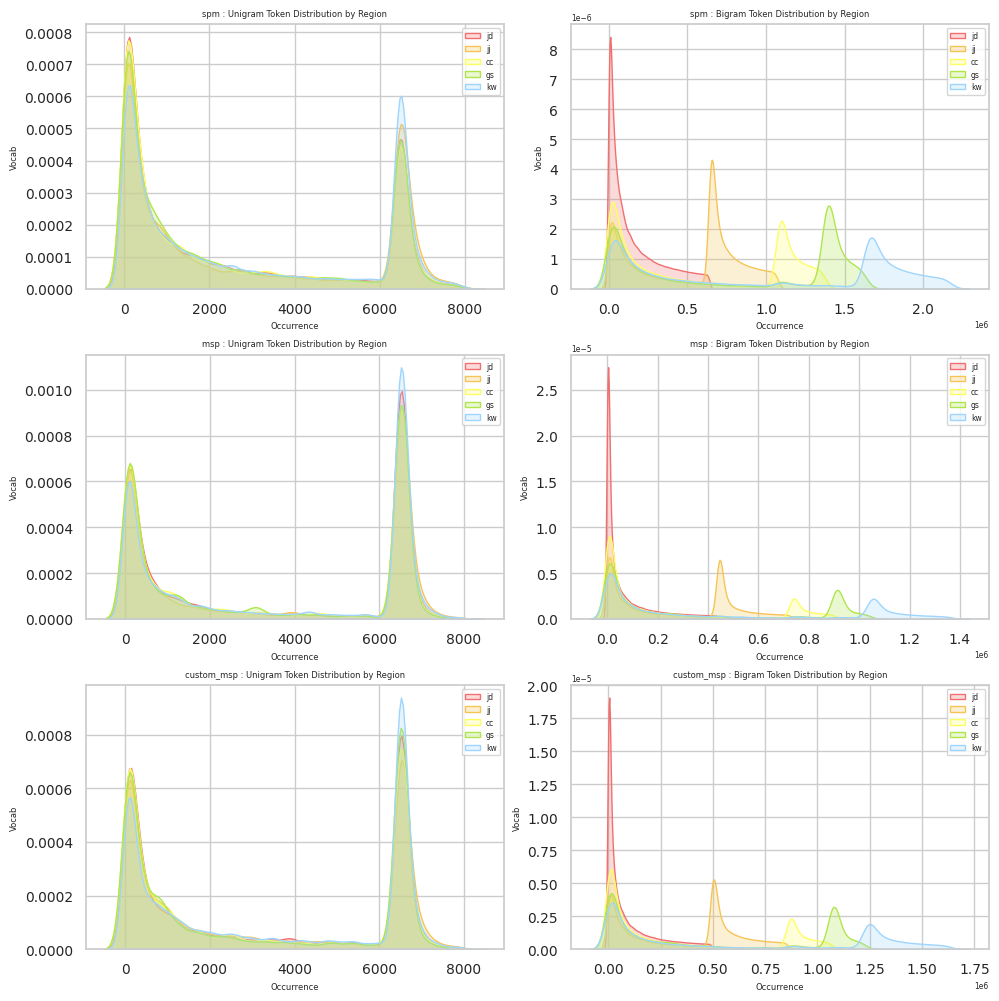

In [116]:
uni_bi_distribution_plot(tokenizers_8000, 3, 2, df_t, 'dial_edit_r')

In [221]:
use_col = ['reg', 'topic', 'stdn','eng_n', 'dial_edit']

In [222]:
df_t = df_t[use_col]

In [223]:
df_t.rename(columns={'eng_n' :'eng','dial_edit':'dial'}, inplace=True)

In [224]:
df_t.to_csv(dir_path + '/final_data_0324.csv')

In [225]:
df_t.loc[df_t.eng.str.contains('dick')]

,reg,topic,stdn,eng,dial


In [226]:
en_t = []
dial_t = []
for i in range(len(df_t)) :
    en_match = re.search('\.|\.|\?|\!$',df_t.eng.values[i])
    dial_match = re.search('\.|\.|\?|\!$',df_t.dial.values[i])
    if not en_match and dial_match :
        en_t.append(df_t.eng.values[i] + re.search('\.|\.|\?|\!$',df_t.dial.values[i]).group())
        dial_t.append(df_t.dial.values[i])
    else :
        en_t.append(df_t.eng.values[i])
        dial_t.append(df_t.dial.values[i])
        
df_t['eng_punctuation'] = en_t
del df_t['eng']
df_t =df_t.rename(columns = {'eng_punctuation':'eng'})

In [227]:
df_test = pd.DataFrame(columns=df_t.columns)

In [228]:
for reg in regs :
    temp_ = df_t.loc[df_t.reg==reg].sample(25, random_state=20)
    df_test = pd.concat([df_test,temp_], axis=0)

In [229]:
df_test.sample(50)

,reg,topic,stdn,dial,eng
504699,kw,연애/결혼,으으 난 지금 장이 비틀려.,으으 난 지굼 장이 비틀려.,"Oh, I'm a mess right now."
307751,kw,건강,저기요 할머니 저기 씨씨티비에 모든 장면 다 남아있어요.,저게요 할먹다구 저 씨씨티비에 모든 장면 다 남아있사.,"Hey, Grandma, there's all that's left over in ..."
653808,gs,회사/학교,어~ 그~ 어떤 보통 이렇게 뭐~ 대학이든 아니면은 뭐~ 사회생활하다 보면은,어~ 어떤 보통 이케 대학이든 아니믄은 사회생활하대이 보믄은,When youre in college or social life
248793,jj,가족,쓰러져서 가로등이 있어요 뭐가 있어요,쓰러져부난 가로등이 있수과 뭐가 있수과,He's down. He's got street lights. He's got so...
650865,gs,아르바이트,그러니까 회사들이 다르게 공고를 내봤자 얼마나 다르겠어 그런 거 좀 찾아봐야,근꼬 회사들이 따르께 공고를 내봤대이 얼매나 다르겠노 그런 거 좀 찾아봐야,So if companies made different announcements I...
97945,cc,영화,나는 인간의 누구나 선한 마음은 가지고 있을 거라고 생각을 해 그러니까,나는 인간의 누구나 선한 마음은 가주구 있을 거라구 생각을 혀 긍까,"I think everyone has a good mind, so."
922232,jj,스타일,이런 거 보는 거 너무 재밌지 않아?,이런 거 보는 거 너무 재밌주이 않?,Isnt it so fun to watch things like this?
936332,cc,날씨,나가 다른 지역들도 -눈- 눈보다는 폭설이 와서,나가 따른 지역들도 눈보다는 폭설이 와서,Go out other areas also had heavy snow rather ...
790141,cc,아르바이트,그러면서 또 매장 고객 받아야지요.,그면서 또 매장 고객 받아야지유.,And then you have to get a customer at the store.
224329,jj,가족,걔가 하는 말이 뭔 줄 알아,가이가 하는 말이 뭔 줄 알아,Do you know what hes saying


In [230]:
test_idx = df_test.index

In [235]:
df_train = df_t.loc[~df_t.index.isin(test_idx)]

In [237]:
assert len(df_train) + len(df_test) == len(df_t)

In [238]:
df_train.to_csv(dir_path + '/train_data_0324.csv')
df_test.to_csv(dir_path + '/test_data_0324.csv')